## Make a simple synthetic dataset to test hierarchical merge in FOF algorithm

#### the idea is this: 

* after the local FOF stage, each partition reports the particles it holds in the overlap region
* do a reduceByKey or treeAggregate of some sort to collect the groups belonging to the same particles
* produce a mapping of $G -> G_1$ and distribute to all hosts in form of broadcast lookup table

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

import sys
sys.setrecursionlimit(sys.getrecursionlimit()*10)

/Users/rok/miniconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import matplotlib.patches as patches

In [3]:
from scipy.spatial import Rectangle

In [754]:
import copy

class DomainRectangle(Rectangle):
    def __init__(self, mins, maxes, N=None, parent=None, tau=0.1):
        self.parent = parent
        super(DomainRectangle, self).__init__(mins,maxes)
        self.children = []
        self.midpoint = self.mins + (self.maxes-self.mins)/2.
        
        if N is None: 
            self.N = 0
        else: 
            self.N = N
        
        self.tau = tau
        
        self.bufferRectangle = Rectangle(self.mins+tau, self.maxes-tau)
        
    def __repr__(self):
        return "<DomainRectangle %s>" % list(zip(self.mins, self.maxes))
    
    def get_inner_box(self, tau): 
        """Return a new hyper rectangle, shrunk by tau"""
    
        new_rect = copy.copy(self)
        new_rect.mins = self.mins + tau
        new_rect.maxes = self.maxes - tau
        
        return new_rect
    
    def split(self, d, split, N): 
        """
        Produce two hyperrectangles by splitting.
        In general, if you need to compute maximum and minimum
        distances to the children, it can be done more efficiently
        by updating the maximum and minimum distances to the parent.
        Parameters
        ----------
        d : int
            Axis to split hyperrectangle along.
        split : float
            Position along axis `d` to split at.
        """
        mid = np.copy(self.maxes)
        mid[d] = split
        less = DomainRectangle(self.mins, mid, N=N, parent=self, tau=self.tau)
        mid = np.copy(self.mins)
        mid[d] = split
        greater = DomainRectangle(mid, self.maxes, N=N, parent=self, tau=self.tau)

        return less, greater
    
    def split_domain(self, max_N = 1, N=1): 
        ndim = len(self.maxes)

        # Keep splitting until max level is reached 
        if N <= max_N: 
            split_point = self.mins + (self.maxes - self.mins)/2
            rs = self.split(0,split_point[0],N)

            # split along all dimensions
            for axis in range(1,ndim):
                rs = [r.split(axis,split_point[axis],N) for r in rs]

                if isinstance(rs[0], (tuple, list)):
                    rs = [item for sublist in rs for item in sublist]

            self.children = rs
    
            res = flatten([r.split_domain(max_N, N+1) for r in rs])

            return res

        else: 
            return self

        
    def in_buffer_zone(self, p):
        """Determine whether a particle is in the buffer zone"""
        in_main = bool(not self.min_distance_point((p['x'], p['y'])))
        in_buffer = bool(not self.bufferRectangle.min_distance_point((p['x'], p['y'])))
        return (in_main != in_buffer)


def partition_particles(particles, domain_containers, tau):
    """Copy particles in buffer areas to the partitions that will need them"""
    
    n_levels = domain_containers[0].N
    
    trans = np.array([[1,1],[-1,-1]])
    
    for p in particles: 
        my_bin = get_bin(p['x'], p['y'], 2**n_levels, [-1,-1], [1,1])
        
        my_rect = domain_containers[my_bin]
        
        if my_rect.in_buffer_zone(p): 
            limits = [list(my_rect.maxes)] + [list(my_rect.mins)]
        
            # particle coordinates in single array
            coords = np.array((p['x'], p['y']))
            
            # get a matrix with distances from all edges
            x = (np.abs([coords - lim for lim in limits]) < tau) * tau

            # if there are nonzero elements, we need to have multiple copies of this particle
            if np.any(x):
                x[1:] *= -1 # the second row are the minimums, i.e. will shif axes to the right/up
                rows, cols = x.nonzero()

                # go through the nonzero rows
                for row, col in zip(rows, cols):
                    new_coords = np.copy(coords)
                    new_coords[col] += x[row,col]
                    new_bin = get_bin(*(new_coords), nbins=2**n_levels, mins=[-1,-1], maxs=[1,1])
                    print coords, x, new_bin, p
                    yield (new_bin, p)
        yield (my_bin, p)

In [770]:
from math import floor, ceil
def get_bin(px, py, nbins, mins, maxs): 
    minx, miny = mins
    maxx, maxy = maxs
    
    if not all([minx<=px<=maxx, miny<=py<=maxy]):
        return -1 
    
    dx = (maxx - minx)/float(nbins)
    dy = (maxy - miny)/float(nbins)
  #  dz = (p_maxs['z'] - p_mins['z'])/float(nbins)
    xbin = floor((px - minx)/dx)
    ybin = floor((py - miny)/dy)
 #   zbin = floor((p['z'] + 1)/dz)
    return int(xbin + ybin*nbins)# + zbin*nbins*nbins)

def flatten(S):
    if S == []:
        return S
    if isinstance(S[0], list):
        return flatten(S[0]) + flatten(S[1:])
    return S[:1] + flatten(S[1:])


def plot_rectangle(rec, ax=None):
    if ax is None: 
        ax = plt.subplot(aspect='equal')
    
    if isinstance(rec, (list, tuple)):
        for r in rec: 
            plot_rectangle(r,ax)
    
    else:
        size = (rec.maxes-rec.mins)
        ax.add_patch(patches.Rectangle(rec.mins, size[0], size[1], fill=False))
    
    plt.xlim(-1.1,1.1); plt.ylim(-1.1,1.1)
    
def get_rectangle_bin(rec, mins, maxs, nbins):
    # take the midpoint of the rectangle
    point = rec.mins + (rec.maxes - rec.mins)/2.
    return get_bin(point[0], point[1], nbins, mins, maxs)

In [771]:
class groupID:
    pass

In [772]:
# data = np.zeros((20,2))
# for i in range(len(data)): 
#     data[i] = np.random.rand(2)*2 - 1 
dt = np.dtype([('x','f8'), ('y', 'f8'), ('pid', 'int'), ('gid', 'f8')])
data = np.zeros(9, dtype=dt)


In [773]:
data[0] = (-.35,-.35,0,1)
data[1] = (-.27,-.27,1,1)
data[2] = (-.23,-.23,2,1)
data[3] = (-.19,-.19,3,1)
data[4] = (-.01,-.01,4,1)
data[5] = (0.01,0.01,5,1)
data[6] = (0.30,0.30,6,1)
data[7] = (0.49,0.49,7,1)
data[8] = (0.51,0.51,8,1)

In [774]:
N=3
D = DomainRectangle([1,1], [-1,-1], tau = 0.05)
domain_containers = D.split_domain(max_N=N)
for r in domain_containers: 
    r.bin = get_rectangle_bin(r, D.mins, D.maxes, 2**N)

domain_containers.sort(key=lambda x: x.bin)

In [775]:
domain_containers[0].tau

0.05

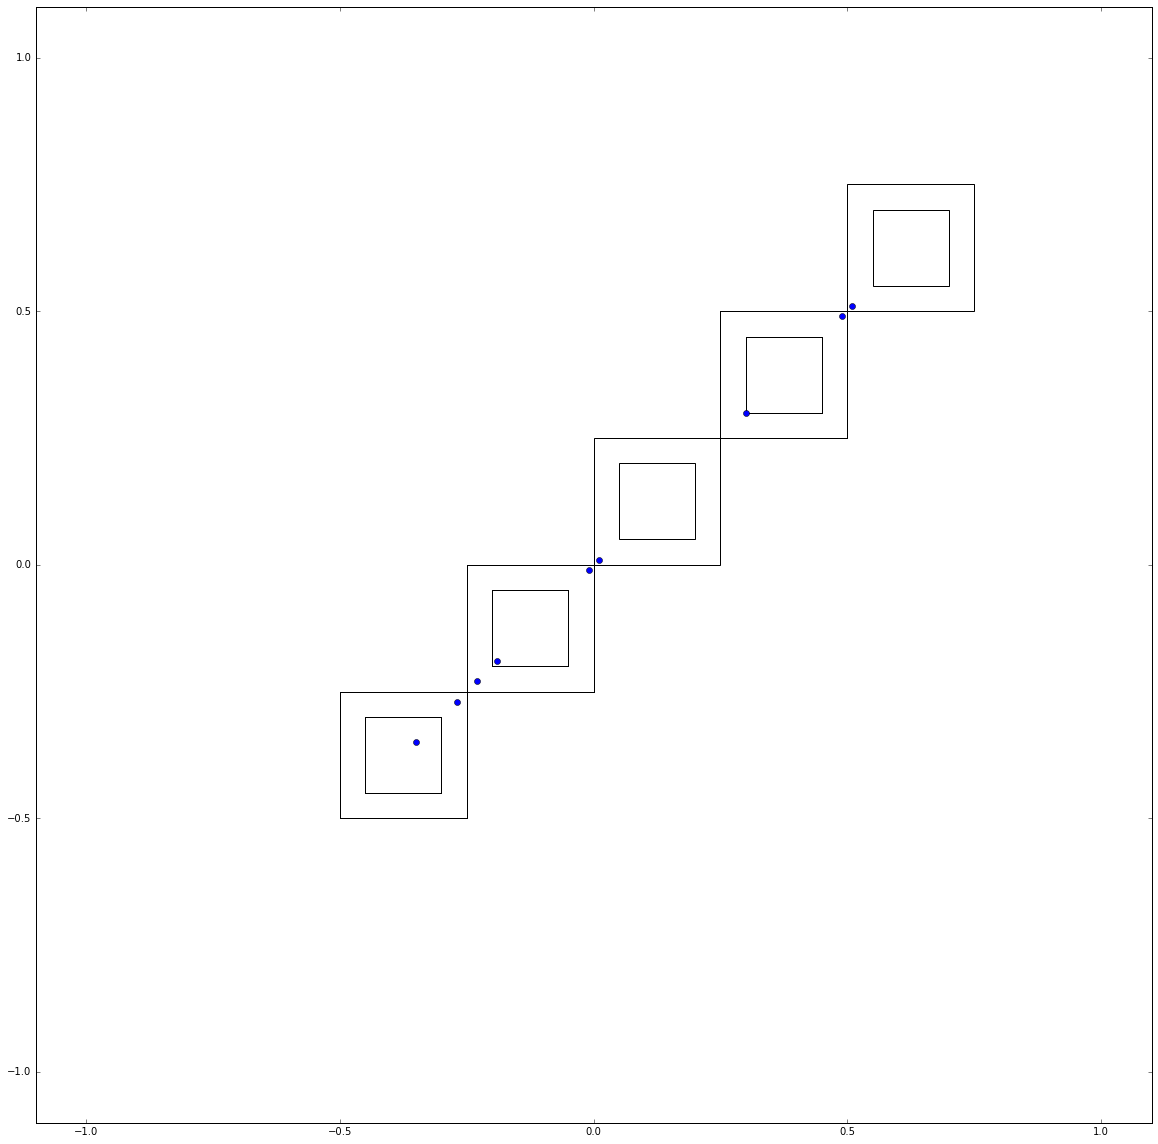

In [776]:
f, ax = plt.subplots(subplot_kw={'aspect':'equal'}, figsize=(20,20))
#plot_rectangle(domain_containers[0].bufferRectangle, ax=ax)
for p in data: 
    plot_rectangle(domain_containers[get_bin(p['x'], p['y'], 2**N, D.mins, D.maxes)], ax=ax)
    plot_rectangle(domain_containers[get_bin(p['x'], p['y'], 2**N, D.mins, D.maxes)].bufferRectangle, ax=ax)
ax.plot(data['x'], data['y'], 'o')

In [331]:
import findspark
findspark.init()

In [332]:
import pyspark
from pyspark import SparkContext

In [80]:
sc = SparkContext(master='local[4]')

In [777]:
p_rdd = sc.parallelize(data)

In [778]:
p_rdd.getNumPartitions()

4

In [779]:
# partitioning duplicates the particles that are located in the boundary regions
part_rdd = (p_rdd.mapPartitions(lambda particles: partition_particles(particles, domain_containers, tau))
                 .partitionBy(len(domain_containers)))
                # .values())

In [780]:
part_rdd.glom().collect()

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [(18, (-0.35, -0.35, 0, 1.0)), (18, (-0.27, -0.27, 1, 1.0))],
 [(19, (-0.27, -0.27, 1, 1.0)), (19, (-0.23, -0.23, 2, 1.0))],
 [],
 [],
 [],
 [],
 [],
 [],
 [(26, (-0.27, -0.27, 1, 1.0)), (26, (-0.23, -0.23, 2, 1.0))],
 [(27, (-0.23, -0.23, 2, 1.0)),
  (27, (-0.19, -0.19, 3, 1.0)),
  (27, (-0.01, -0.01, 4, 1.0))],
 [(28, (-0.01, -0.01, 4, 1.0)), (28, (0.01, 0.01, 5, 1.0))],
 [],
 [],
 [],
 [],
 [],
 [],
 [(35, (-0.01, -0.01, 4, 1.0)), (35, (0.01, 0.01, 5, 1.0))],
 [(36, (0.01, 0.01, 5, 1.0))],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [(45, (0.3, 0.3, 6, 1.0)), (45, (0.49, 0.49, 7, 1.0))],
 [(46, (0.49, 0.49, 7, 1.0)), (46, (0.51, 0.51, 8, 1.0))],
 [],
 [],
 [],
 [],
 [],
 [],
 [(53, (0.49, 0.49, 7, 1.0)), (53, (0.51, 0.51, 8, 1.0))],
 [(54, (0.51, 0.51, 8, 1.0))],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 []]

In [515]:
data_fof = np.zeros(8, dtype=dt)

data_fof[0] = (-.85,-.85,0,1.1)
data_fof[1] = (-.5,-.5,1,2.1)
data_fof[2] = (-.05,-.5,2,3.1)
data_fof[3] = (-.05,-.55,3,3.1)
data_fof[4] = (-.05,-.5,2,1.2)
data_fof[5] = (-.05,-.55,3,1.2)
data_fof[6] = (.05, -.55,4,1.2)
data_fof[7] = (.11,-.55,5,1.2)

data_partitions = [0,0,0,0,1,1,1,1]

In [521]:
fof_rdd = sc.parallelize(zip(data_partitions, data_fof)).partitionBy(4).values()

In [522]:
fof_rdd.glom().collect()

[[(-0.85, -0.85, 0, 1.1),
  (-0.5, -0.5, 1, 2.1),
  (-0.05, -0.5, 2, 3.1),
  (-0.05, -0.55, 3, 3.1)],
 [(-0.05, -0.5, 2, 1.2),
  (-0.05, -0.55, 3, 1.2),
  (0.05, -0.55, 4, 1.2),
  (0.11, -0.55, 5, 1.2)],
 [],
 []]

In [620]:
def get_buffer_particles(partition, particles): 
    """Produce the particles from the buffer regions"""
    my_rect = domain_containers[partition]
    
    for p in particles: 
        if my_rect.in_buffer_zone(p): 
            yield p


def pid_gid(p): 
    return (p['pid'], p['gid'])

def remap_pid_gid(p, gid_map):
    """Change the particle's gid if it exists in the map"""
    if p['gid'] in gid_map.keys(): 
        new_p = copy.copy(p)
        new_p['gid'] = gid_map[p['gid']]
        return new_p
    else:
        return p
    
def get_gid_map(particle_rdd): 
    """Take a particle RDD and return a pid -> gid mapping for particles in the buffer region.
    
        This is done in two steps: 
            - first, a mapping of buffer region particle IDs to group IDs is made
            - second, the particle IDs corresponsing to the buffer region particles
              are filtered from the full data and a map is produced that maps all groups
              onto the group corresponding to the lowest container ID
              
        Inputs:
        
        particle_rdd: an RDD of numpy array structs
        
        Returns:
        
        mapping for group relabelling    
    """
    res = (particle_rdd.mapPartitionsWithIndex(get_buffer_particles)
                       .map(pid_gid)
                       .groupByKey()).collect()
    
    pg_map = {}
    for pid, gids in res: 
        groups = list(gids)
        groups.sort(key=lambda x: np.modf(x)[0])
        pg_map[pid] = groups[0]
    
    pg_map_b = sc.broadcast(pg_map)
    
    # generate the groups mapping
    groups_map = (particle_rdd.map(pid_gid)
                              .filter(lambda (pid,gid): pid in pg_map_b.value.keys())
                              .aggregateByKey([], lambda l,g: l + [g], lambda a,b: sorted(a+b, key=lambda x: np.modf(x)[0]))
                              .values()
                              .flatMap(lambda gs: [(g, gs[0]) for g in gs[1:]])).collectAsMap()
    
    
    
    return groups_map

In [621]:
groups_map = get_gid_map(fof_rdd)

In [622]:
groups_map

{1.2: 3.1000000000000001}

In [624]:
fof_rdd.collect()

[(-0.85, -0.85, 0, 1.1),
 (-0.5, -0.5, 1, 2.1),
 (-0.05, -0.5, 2, 3.1),
 (-0.05, -0.55, 3, 3.1),
 (-0.05, -0.5, 2, 1.2),
 (-0.05, -0.55, 3, 1.2),
 (0.05, -0.55, 4, 1.2),
 (0.11, -0.55, 5, 1.2)]

In [623]:
fof_rdd.map(lambda p: remap_pid_gid(p, groups_map)).collect()

[(-0.85, -0.85, 0, 1.1),
 (-0.5, -0.5, 1, 2.1),
 (-0.05, -0.5, 2, 3.1),
 (-0.05, -0.55, 3, 3.1),
 (-0.05, -0.5, 2, 3.1),
 (-0.05, -0.55, 3, 3.1),
 (0.05, -0.55, 4, 3.1),
 (0.11, -0.55, 5, 3.1)]